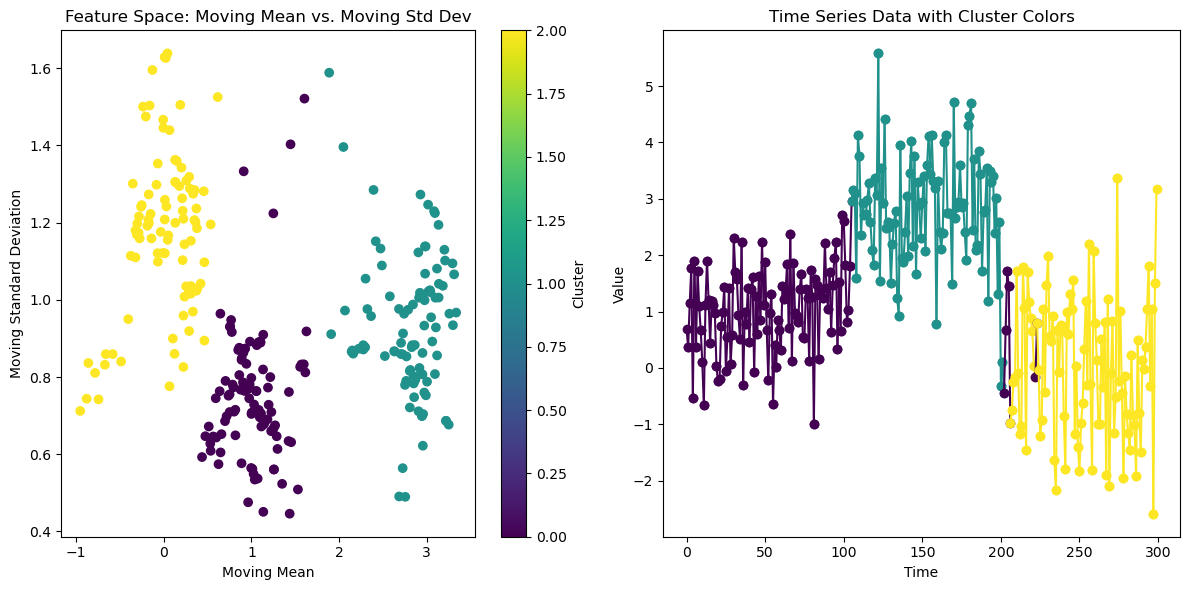

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import igraph as ig
import leidenalg as la
from sklearn.metrics import pairwise_distances

time_series_length = 300

# Function to generate a time series with predefined states
def generate_time_series_with_states():
    time_series = np.zeros(time_series_length)

    # Define states with different means and variances
    state_definitions = [(0, 100, 1, 0.5), (100, 200, 3, 1), (200, 300, 0, 2)]

    for start, end, mean, variance in state_definitions:
        time_series[start:end] = np.random.normal(mean, np.sqrt(variance), end - start)

    return time_series

# Generate the time series
time_series = generate_time_series_with_states()
time_series = pd.Series(time_series)

# Calculate moving mean and standard deviation with a window size of 10
window_size = 10
moving_means = time_series.rolling(window=window_size).mean().iloc[window_size - 1:]
moving_stds = time_series.rolling(window=window_size).std().iloc[window_size - 1:]

# Prepare feature vectors (excluding NaN values)
features = np.column_stack((moving_means.dropna(), moving_stds.dropna()))

# Create a graph based on Euclidean distances and a threshold for edge creation
similarity_matrix = np.exp(-pairwise_distances(features, metric="euclidean"))
threshold = np.median(similarity_matrix)

g = ig.Graph()
num_points = len(features)
g.add_vertices(num_points)

edges = [(i, j) for i in range(num_points) for j in range(i + 1, num_points) if similarity_matrix[i, j] > threshold]
weights = [similarity_matrix[i, j] for i, j in edges]

g.add_edges(edges)
g.es['weight'] = weights

# Apply the Leiden algorithm to detect clusters
partition = la.find_partition(g, la.ModularityVertexPartition, weights='weight')

# Assign a cluster label to each point in the feature space
cluster_labels = np.zeros(num_points)
for cluster_num, cluster in enumerate(partition):
    for index in cluster:
        cluster_labels[index] = cluster_num

# Extend cluster labels to the entire time series
extended_cluster_labels = np.full(time_series_length, np.nan)  # Initialize with NaNs
for i, label in enumerate(cluster_labels):
    extended_cluster_labels[i + window_size - 1] = label  # Align labels with the center of the window

# Avoid plot breaks by setting initial cluster for NaN values
extended_cluster_labels[:window_size - 1] = extended_cluster_labels[window_size - 1]

# Plotting
plt.figure(figsize=(12, 6))

# Scatter plot for features
plt.subplot(1, 2, 1)
scatter = plt.scatter(moving_means, moving_stds, c=cluster_labels, cmap='viridis')
plt.title('Feature Space: Moving Mean vs. Moving Std Dev')
plt.xlabel('Moving Mean')
plt.ylabel('Moving Standard Deviation')
plt.colorbar(scatter, label='Cluster')

# Time series line plot with cluster-based coloring
plt.subplot(1, 2, 2)
for i in range(1, time_series_length):
    plt.plot([i - 1, i], [time_series[i - 1], time_series[i]], 'o-', color=plt.cm.viridis(extended_cluster_labels[i] / np.nanmax(extended_cluster_labels)))

plt.title('Time Series Data with Cluster Colors')
plt.xlabel('Time')
plt.ylabel('Value')

plt.tight_layout()
plt.show()
